## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, InputSpec
from keras.utils import *
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from scipy.sparse import lil_matrix

## Read Data

In [2]:
data = pd.read_csv('1. Pima Indiana diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data = data.drop_duplicates(ignore_index=True)
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.iloc[:, -1].unique()

array([1, 0], dtype=int64)

## Data Visualization

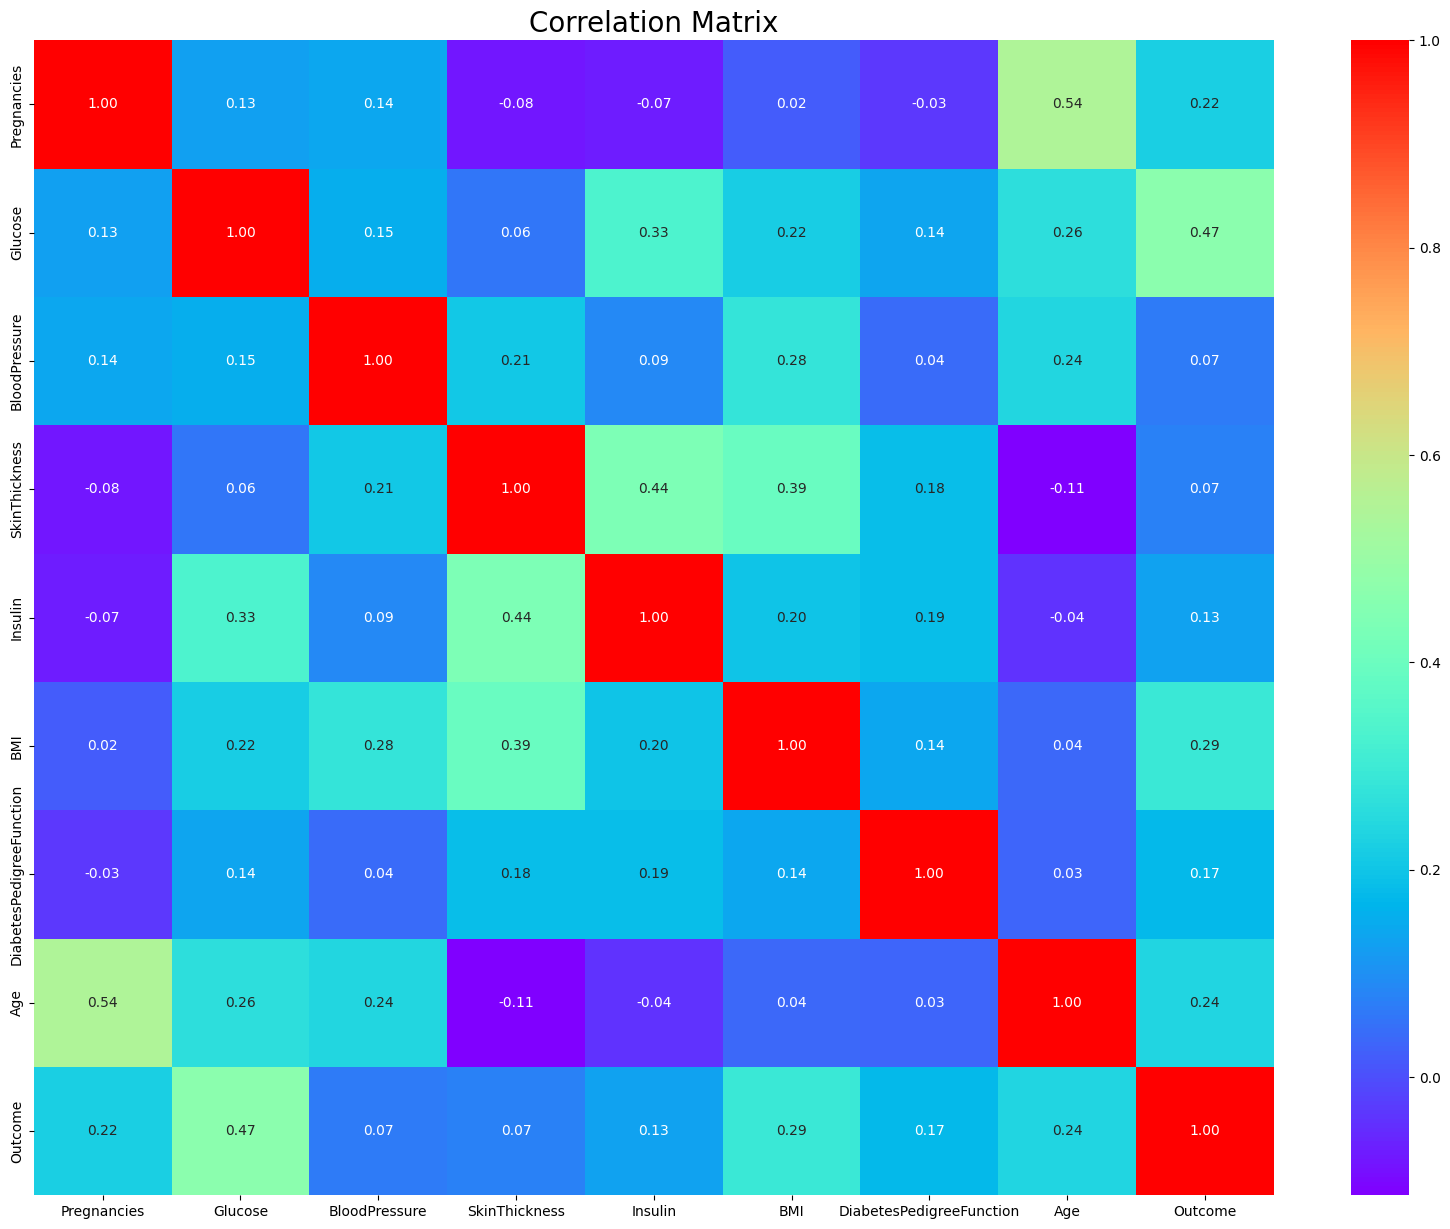

In [6]:
f, ax = plt.subplots(figsize= [20,15])
corr = data.corr()
sns.heatmap(data.corr(), annot=True, fmt=".2f", ax=ax, cmap = "rainbow" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

## Data Preprocessing

In [7]:
scaler = MinMaxScaler()
scaler.fit(data)

# Transform the DataFrame to obtain the normalized data
data_normalized = scaler.transform(data)

In [8]:
X = data_normalized[:, :-1]
y = data_normalized[:, -1]

In [9]:
X.shape[-1]

8

## Modelling

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
def DNNModel(in_dim, out_dim):
    model = Sequential([
        tf.keras.layers.Input(shape=in_dim),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(out_dim, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
    return model

## Cross Validation

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [13]:
fold_test = []
fold_pred = []

In [14]:
from sklearn.metrics import accuracy_score
from torchmetrics.functional.classification import binary_accuracy, binary_auroc, binary_f1_score, binary_precision, binary_recall

In [15]:
for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    x_train, x_test, y_train, y_test = (X[train_idx]), (X[test_idx]), (y[train_idx]), (y[test_idx])
    classifier = DNNModel(8, 1)
    
    train_init = time.time()
    classifier.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    train_time = time.time() - train_init

    test_init = time.time()
    prediction = classifier.predict(x_test)
    test_time = time.time() - test_init

    fold_test.append(y_test)
    fold_pred.append(prediction)

    preds = torch.tensor(prediction.flatten())
    trues = torch.tensor(y_test)

    print(f"Fold: {fold+1} | Accuracy: {binary_accuracy(preds=preds, target=trues).item():.5f} | Train Time: {train_time} | Test Time: {test_time}")  

3/3 [==============================] - 0s 11ms/step
Fold: 1 | Accuracy: 0.74026 | Train Time: 7.71985125541687 | Test Time: 0.1533956527709961
3/3 [==============================] - 0s 2ms/step
Fold: 2 | Accuracy: 0.81818 | Train Time: 6.309152603149414 | Test Time: 0.0657808780670166
3/3 [==============================] - 0s 1ms/step
Fold: 3 | Accuracy: 0.67532 | Train Time: 5.963629245758057 | Test Time: 0.06764578819274902
3/3 [==============================] - 0s 2ms/step
Fold: 4 | Accuracy: 0.87013 | Train Time: 5.8037269115448 | Test Time: 0.08319258689880371
3/3 [==============================] - 0s 2ms/step
Fold: 5 | Accuracy: 0.81818 | Train Time: 6.011629819869995 | Test Time: 0.11726021766662598
3/3 [==============================] - 0s 2ms/step
Fold: 6 | Accuracy: 0.71429 | Train Time: 5.97252631187439 | Test Time: 0.06874465942382812
3/3 [==============================] - 0s 2ms/step
Fold: 7 | Accuracy: 0.79221 | Train Time: 5.9954657554626465 | Test Time: 0.07094025611877

In [16]:
accuracy = []
precision = []
recall = []
f1_score = []
auroc = []

for i in range(10):
    trues = torch.tensor(fold_test[i])
    preds = torch.tensor(fold_pred[i].flatten())
    accuracy.append(binary_accuracy(preds=preds, target=trues).item())
    precision.append(binary_precision(preds=preds, target=trues).item())
    recall.append(binary_recall(preds=preds, target=trues).item())
    f1_score.append(binary_f1_score(preds=preds, target=trues).item())
    auroc.append(binary_auroc(preds.float(), trues.long()).item())

print(f"Accuracy: {np.mean(accuracy):.5f} | Precision: {np.mean(precision):.5f} | Recall: {np.mean(recall):.5f} | F1 Score: {np.mean(f1_score):.5f} | AUC ROC: {np.mean(auroc):.5f}")

Accuracy: 0.76034 | Precision: 0.68608 | Recall: 0.60287 | F1 Score: 0.63731 | AUC ROC: 0.81945
